In [1]:
import pandas as pd
import mwparserfromhell
from bs4 import BeautifulSoup
from datetime import date, datetime, timedelta
import requests
import numpy as np
import time

/Users/nathan/Projects/school/cs5830/cs5830final/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Reading all text files from the "selected articles by rank" folder
folder_path = "selected articles by rank"

df = pd.read_csv("output.csv")

# Looping through all files
for file_name in ["Stub_selected.txt", "Start_selected.txt", "C_selected.txt", "B_selected.txt", "GA_selected.txt", "FA_selected.txt"]:
    print(file_name)
    if file_name.endswith(".txt"):
        parts = file_name.split("_")
        ranking = parts[0]  # The part before the underscore (e.g., "A", "B")

        with open(f"{folder_path}/{file_name}", "r") as file:
            lines = file.readlines()

            # Iterate over each line in the file
            for line in lines:
                line = line.strip() # Remove leading/trailing whitespace
                # If the line matches a title in the DataFrame, assign the ranking
                df.loc[df['Title'] == line, 'Ranking'] = ranking

df

In [ ]:
# aggregate these values
df["Grammar Quality"] = df["n_acceptable"] / (df["n_acceptable"] + df["n_unacceptable"])
df["Bias"] = abs(df['n_positive'] - df['n_negative']) / (df['n_positive'] + df['n_negative'])
df

In [ ]:
print("reading file...")
# Load the XML file
with open('extracted.xml', 'r') as file:
    xml_data = file.read()

print("parsing file...")
# Parse the XML using BeautifulSoup
soup = BeautifulSoup(xml_data, 'lxml')

In [ ]:
pages = soup.find_all('page')

templates_of_interest = {
    # Major edit
    'In use',
    'Under construction',
    'In use section',
    # New articles
    'In creation',
    # protected
    'pp-dispute',
    'pp-vandalism',
    'pp-protected',
    'pp-sock',
    'pp-move',
    'pp-office',
    # copyright violations
    'Copyvio',
    'Copyvio-revdel',
    'Copypaste',
    'Close paraphrasing',
    'Copyvio links',
    # significant attention
    "Multiple issues",
    "Expert needed",
    "Missing information",
    "ISSN-needed",
    "Citations broken from PEIS limit",
    # general cleanup
    "cleanup",
    "cleanup AfD",
    "cleanup rewrite",
    "section rewrite",
    "cleanup section",
    # fiction issues
    "all plot",
    "fiction",
    "in-universe",
    "long plot",
    "more plot",
    "no plot",
    # style issues
    'abbreviations',
    'buzzword',
    'Cleanup press release',
    'cleanup tense',
    'debate',
    'essay-like',
    'excessive examples',
    'how-to',
    'inappropriate person',
    'Resume-like',
    'manual',
    'obituary',
    'over-quotation',
    'peacock',
    'pro and con list',
    'promotional',
    'research paper',
    'review',
    'speculation',
    'story',
    'technical',
    'tone',
    'travel guide',
    # structure issues
    'cleanup reorganize',
    'copy edit',
    'duplication',
    'importance section',
    'organize section',
    'overcolored',
    'overcoloured',
    'sections',
    'summarize section',
    'Too many sections',
    'Too many see alsos',
    'trivia',
    'very long'
    # contradiction and confusion
    'confusing',
    'contradicts other',
    'contradicts others',
    'incomprehensible',
    'misleading',
    'self-contradictory',
    'unclear date',
    'unfocused',
    # importance and notability
    'importance',
    'importance section',
    'importance inline',
    'notability',
    # neutrality and accuracy
    'autobiography',
    'cherry-picked',
    'coatrack',
    'COI',
    'disputed',
    'disputed section',
    'geographical importance',
    'globalize',
    'hoax',
    'peacock',
    'political POV',
    'POV',
    'POV lead',
    'POV section',
    'recentism',
    'unbaleanced',
    'undisclosed paid',
    'undue weight',
    'weasel',
    # sources and citations
    'cite check',
    'cite check section',
    'excessive citations',
    'more citations needed',
    'more citations needed section',
    'old news',
    'one source',
    'original research',
    'primary sources',
    'self-published',
    'speculation',
    'third-party',
    'unreferenced',
    'unreferenced section',
    'unreliable sources',
    'user-generated'
}

for page in pages:
    title = page.find('title').text
    text = page.find('revision').find('text').text
    wikicode = mwparserfromhell.parse(text)
    templates = wikicode.filter_templates()
    template_names = [template.name.strip() for template in templates]
    for template in template_names:
        if template in templates_of_interest:
            df.loc[df['Title'] == title, f"T:{template}"] = 1

df

In [ ]:
# replace nan with 0 in columns starting in T:
df.loc[:, df.columns.str.startswith("T:")] = df.loc[:, df.columns.str.startswith("T:")].fillna(0)
df

In [ ]:
# reference density
pages = soup.find_all('page')
window = 50

for page in pages:
    # average reference density in a rolling window
    title = page.find('title').text
    text = page.find('revision').find('text').text
    references = []
    lines = text.split("\n")
    for line in lines:
        count = line.count("<ref>") + line.count("\{\{sfn")
        references.append(count)
    density = [sum(references[i-window:i])/window for i in range(window, len(references))]
    df.loc[df['Title'] == title, "Reference Density"] = sum(density) / len(density) if len(density) > 0 else sum(references) / len(references)

df

In [ ]:
# reference quality
pages = soup.find_all('page')

for page in pages:
    title = page.find('title').text
    text = page.find('revision').find('text').text
    wikicode = mwparserfromhell.parse(text)
    references = filter(lambda x: x.name.strip() == "cite web" or x.name.strip() == "cite book" or x.name.strip() == "cite journal", wikicode.filter_templates())
    references_quality = []
    for reference in references:
        score = 0

        if reference.name == "cite journal":
            score += 7
        elif reference.name == "cite book":
            score += 3
        elif reference.name == "cite web":
            if reference.has("url"):
                url = reference.get("url").value.strip()
                if ".edu" in url:
                    score += 7
                elif ".gov" in url:
                    score += 3
                elif ".org" in url:
                    score += 1

        if reference.has("date"):
            ref_date = reference.get("date").value.strip()
            # look for a 4 digit (year) number in date
            ref_date = ref_date.split(" ")
            ref_date = list(filter(lambda x: x.isnumeric() and len(x) == 4, ref_date))
            if len(ref_date) > 0:
                ref_date = date(int(ref_date[0]), 1, 1)
            else:
                ref_date = date(1,1,1)


            if ref_date.year >= date.today().year - 5:
                score += 7
            elif ref_date.year >= date.today().year - 10:
                score += 3
            else:
                score += 1

        score = score / 14
        references_quality.append(score)

    df.loc[df['Title'] == title, "Reference Quality"] = sum(references_quality) / len(references_quality) if len(references_quality) > 0 else 0

df

In [ ]:
# revision history from api
times = []
endpoint = "https://en.wikipedia.org/w/api.php"
titles = df[df['Revisions per Day'].isna()]['Title']

for title in titles:
    start = time.time()

    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": title,
        "rvprop": "timestamp|size|tags",
        "rvlimit": "max"
    }

    response = requests.get(endpoint, params=params)
    data = list(response.json()['query']['pages'].values())[0]['revisions']

    first_timestamp = datetime.fromisoformat(data[-1]['timestamp'].split("T")[0])
    last_timestamp = datetime.fromisoformat(data[0]['timestamp'].split("T")[0])
    total_days = max((last_timestamp - first_timestamp).days, 1)
    total_revisions = len(data)
    revisions_per_day = total_revisions / total_days

    undo_count = sum([1 for revision in data if "mw-undo" in revision['tags']])
    undo_per_revision = undo_count / total_revisions

    sizes = [revision['size'] for revision in data]
    size_diffs = [sizes[i] - sizes[i+1] for i in range(len(sizes) - 1)]
    sizes_mean = np.mean(size_diffs)
    sizes_std = np.std(size_diffs)

    df.loc[df['Title'] == title, "Revisions per Day"] = revisions_per_day
    df.loc[df['Title'] == title, "Undo per Revision"] = undo_per_revision
    df.loc[df['Title'] == title, "Revision Size Mean"] = sizes_mean
    df.loc[df['Title'] == title, "Revision Size Std"] = sizes_std
    end = time.time()
    times.append(end - start)
    print(f"{np.mean(times) * (len(titles) - len(times)) / 60} minutes remaining +/- {np.std(times) * (len(titles) - len(times)) / 60} minutes")

df.to_csv("output_raw.csv", index=False)
df

In [ ]:
df = pd.read_csv("output_raw.csv")

# obsolete columns
df.drop(columns=[
    "Unnamed: 0",
    "n_acceptable",
    "n_unacceptable",
    "n_positive",
    "n_negative",
    "Protected",
    "Style Issues",
    "Significant Attention",
    "Structure Issues",
    "General Cleanup",
    "Fiction Issues",
    "Copyright Violation",
    "Minimum Reference Density"
    ], inplace=True)

# look for columns starting with "T:" that contain no data in any row
empty_columns = df.columns[df.columns.str.startswith("T:")].to_list()
empty_columns = [column for column in empty_columns if df[column].sum() == 0]
df.drop(columns=empty_columns, inplace=True)

df.to_csv("output_clean.csv", index=False)
df

In [ ]:
# forgot to do Reference Count
df = pd.read_csv("output_clean.csv")

pages = soup.find_all('page')

for page in pages:
    # average reference density in a rolling window
    title = page.find('title').text
    text = page.find('revision').find('text').text
    count = text.count("<ref>") + text.count("\{\{sfn")
    df.loc[df['Title'] == title, "Reference Count"] = count

df.to_csv("output_clean.csv", index=False)

# Analysis

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("output_clean.csv")

In [3]:
numeric = [
    "Bytes",
    "Media Count",
    "Grammar Quality",
    "Bias",
    "Reference Count",
    "Reference Density",
    "Reference Quality",
    "Revisions per Day",
    "Undo per Revision",
    "Revision Size Mean",
    "Revision Size Std"
]

# categorical is anything starting with T: and the Ranking column

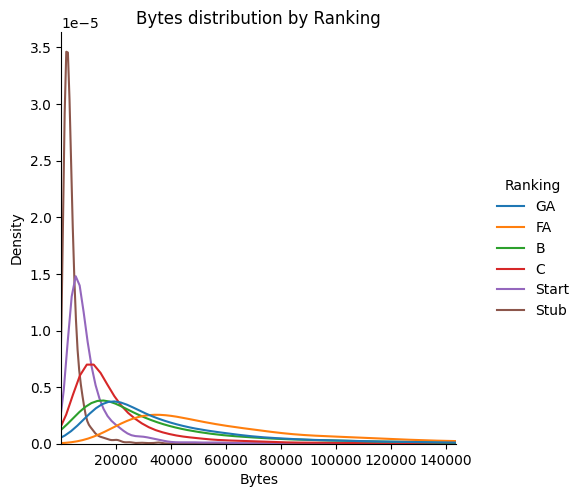

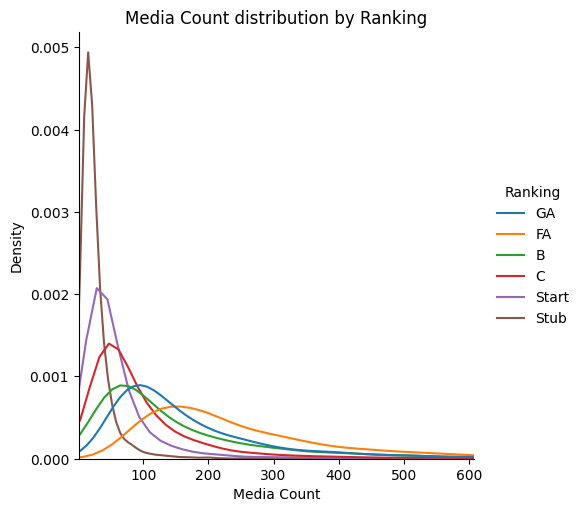

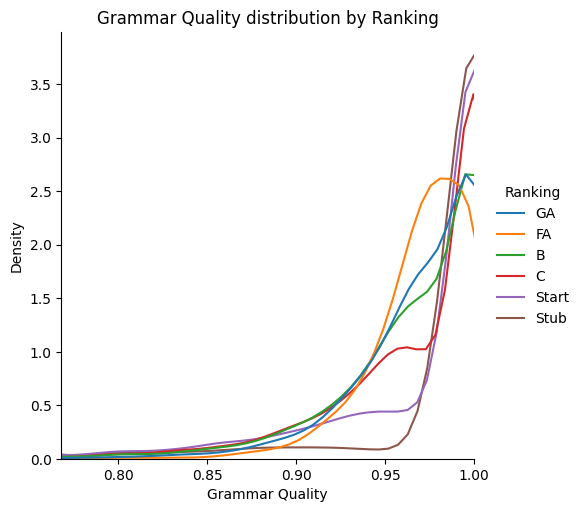

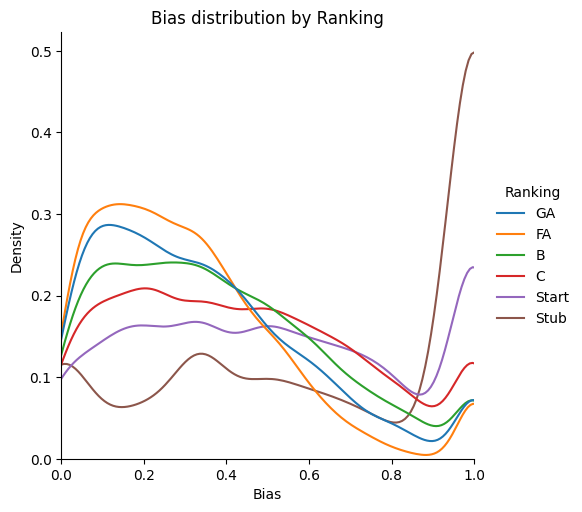

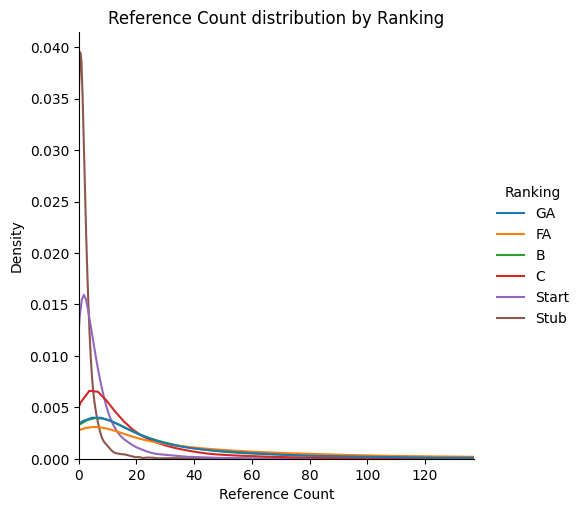

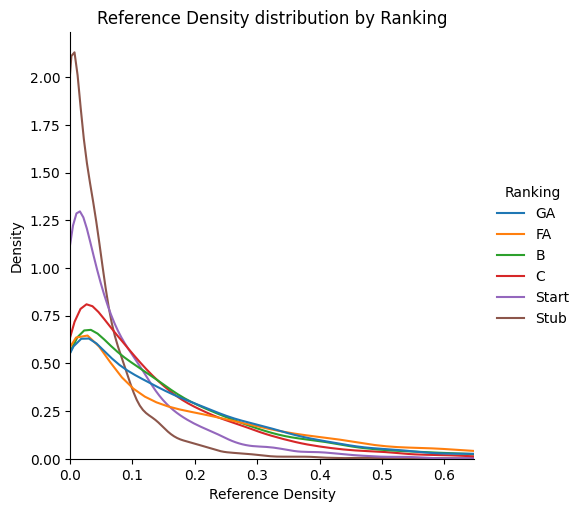

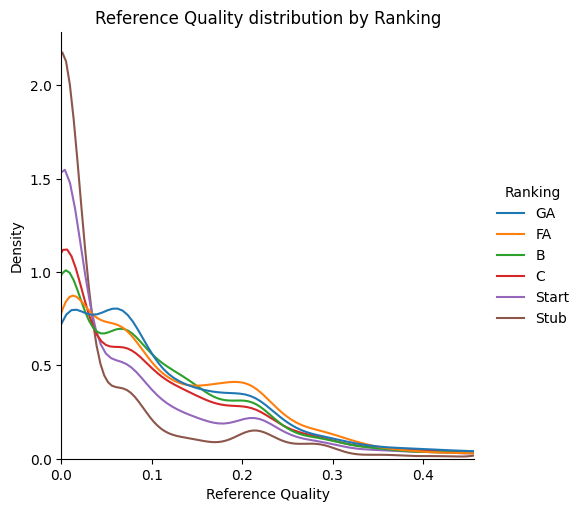

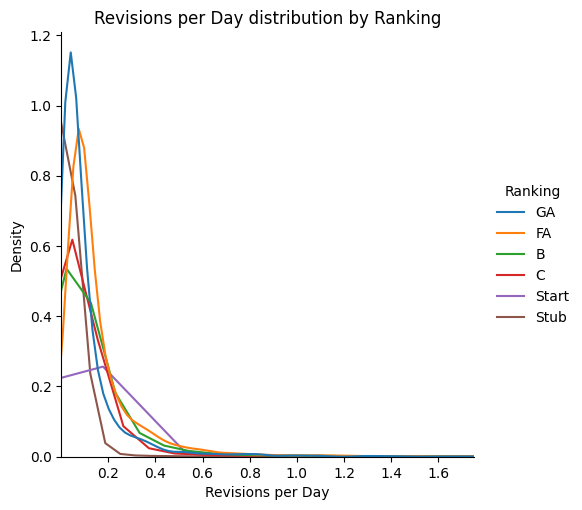

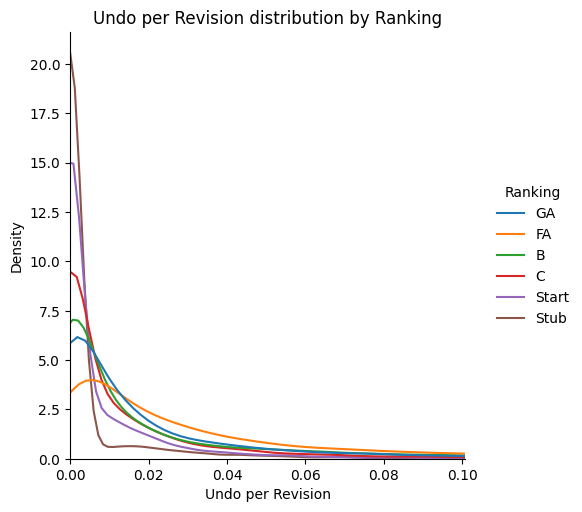

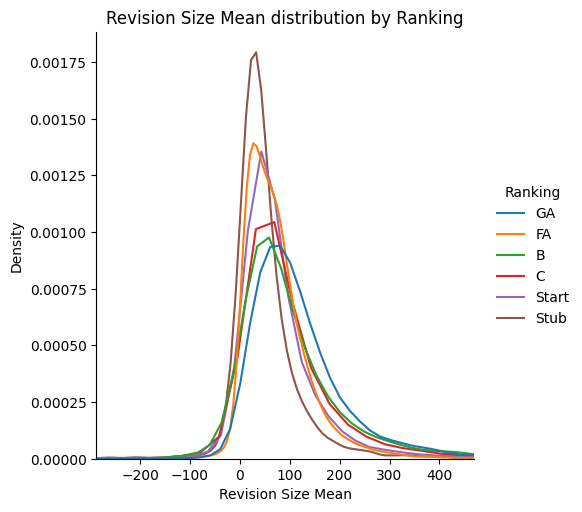

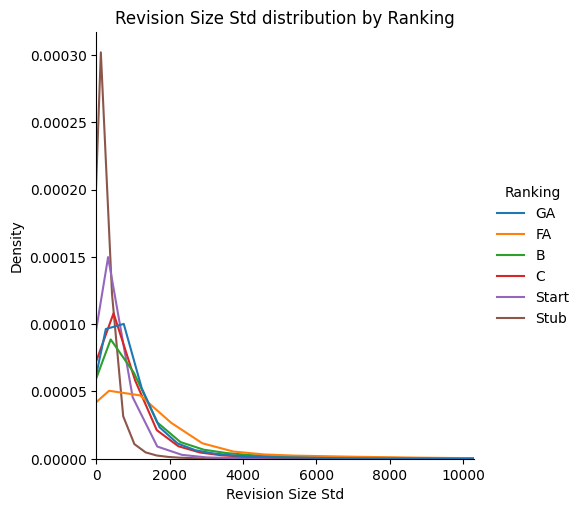

In [4]:
for column in numeric:
    sns.displot(data=df, x=column, hue="Ranking", kind="kde")
    mean = np.mean(df[column])
    std = np.std(df[column])
    plt.xlim(max(mean - 3 * std, np.min(df[column])), min(mean + 3 * std, np.max(df[column])))
    plt.title(f"{column} distribution by Ranking")
    plt.show()

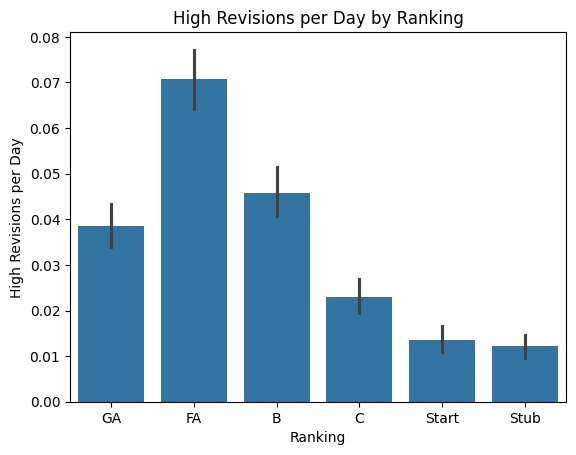

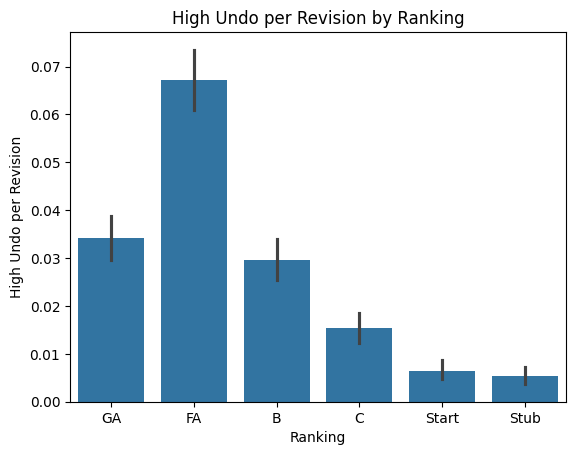

In [5]:
# when it comes to revisions per day and undo per revision, we are actually interested in outliers
# An outlier here indicates that the article is not stable, but under some threshold, this number is not very informative
# so we will turn these into categorical variables, based on a threshold

df["High Revisions per Day"] = df["Revisions per Day"] > 0.4
df["High Undo per Revision"] = df["Undo per Revision"] > 0.1

sns.barplot(data=df, x="Ranking", y="High Revisions per Day")
plt.title("High Revisions per Day by Ranking")
plt.show()

sns.barplot(data=df, x="Ranking", y="High Undo per Revision")
plt.title("High Undo per Revision by Ranking")
plt.show()

In [6]:
df.drop(columns=["Revisions per Day", "Undo per Revision"], inplace=True)

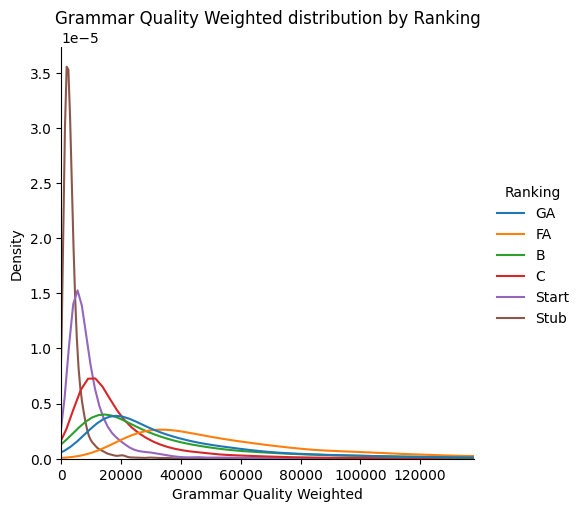

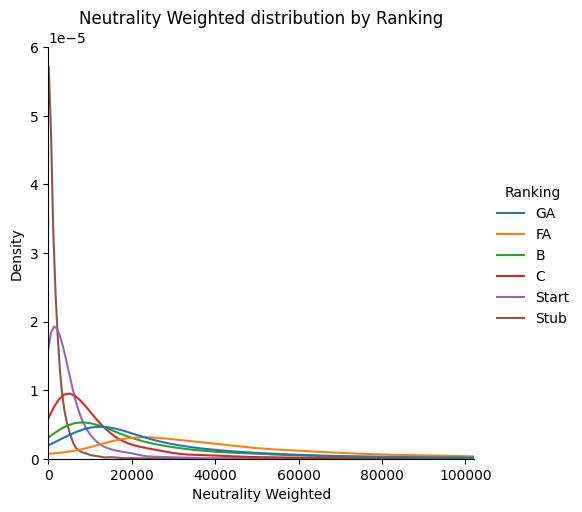

In [7]:
# there are a bunch of 1s in Grammar quality and bias, which indicates very short articles, which are not well ranked
# let's try to wieght the scores by the number of bytes, so as to give more credence to ratings on longer articles
# this makes sense because our metrics are more accurate on longer articles
# for bias, a smaller score is better, so let's create "neutrality", which is 1 - bias
# and then perform the same operation

df["Grammar Quality Weighted"] = df["Grammar Quality"] * df["Bytes"]
df["Neutrality"] = 1 - df["Bias"]
df["Neutrality Weighted"] = df["Neutrality"] * df["Bytes"]


# plot again
for column in ["Grammar Quality Weighted", "Neutrality Weighted"]:
    sns.displot(data=df, x=column, hue="Ranking", kind="kde")
    mean = np.mean(df[column])
    std = np.std(df[column])
    plt.xlim(max(mean - 3 * std, np.min(df[column])), min(mean + 3 * std, np.max(df[column])))
    plt.title(f"{column} distribution by Ranking")
    plt.show()

In [8]:
# looking much better, drop the old columns
df.drop(columns=["Grammar Quality", "Bias", "Neutrality"], inplace=True)

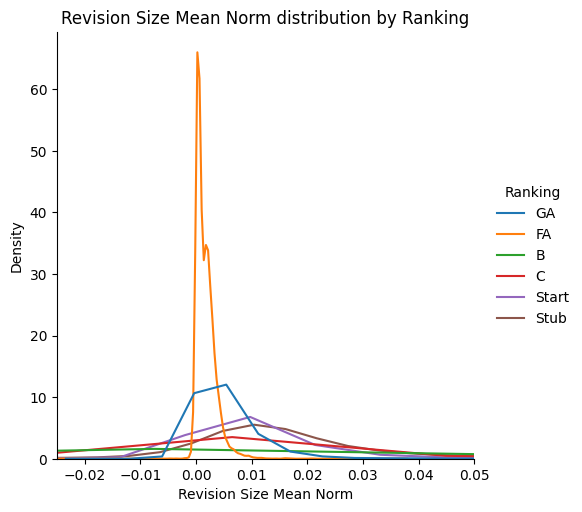

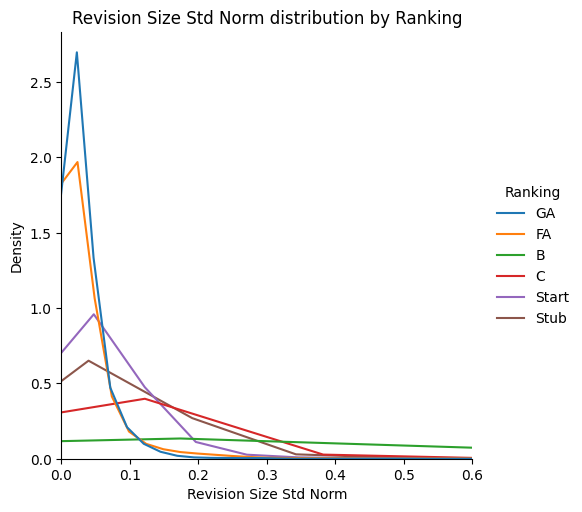

In [9]:
# lets try normalizing Revision Size Mean and Revision Size Std by the size of the article
df["Revision Size Mean Norm"] = df["Revision Size Mean"] / df["Bytes"]
df["Revision Size Std Norm"] = df["Revision Size Std"] / df["Bytes"]

sns.displot(data=df, x="Revision Size Mean Norm", hue="Ranking", kind="kde")
plt.xlim(-0.025, 0.05)
plt.title("Revision Size Mean Norm distribution by Ranking")
plt.show()
sns.displot(data=df, x="Revision Size Std Norm", hue="Ranking", kind="kde")
plt.xlim(0, 0.6)
plt.title("Revision Size Std Norm distribution by Ranking")
plt.show()

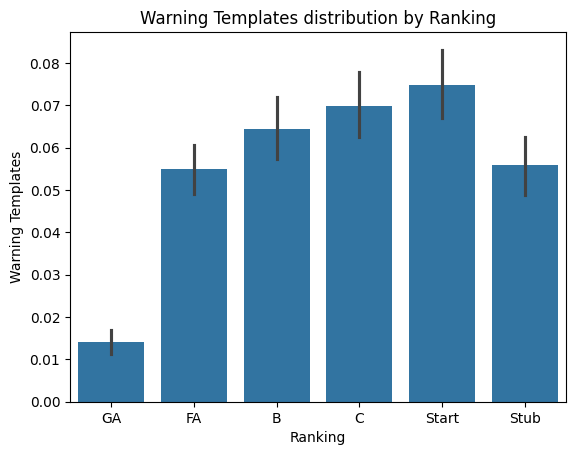

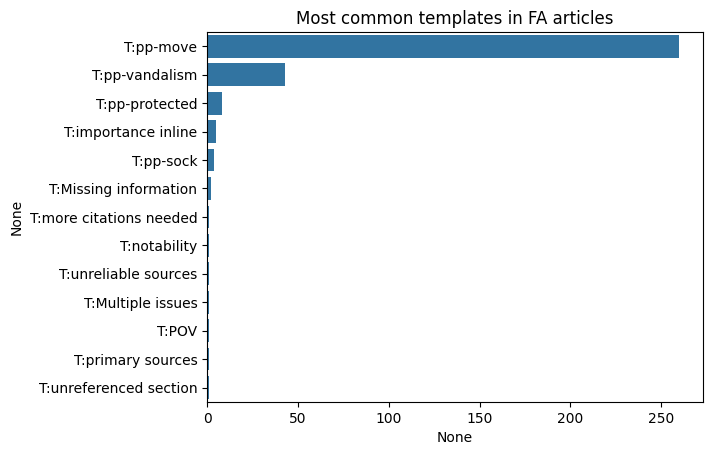

In [10]:
# number of warning templates
df["Warning Templates"] = df.loc[:, df.columns.str.startswith("T:")].sum(axis=1)

sns.barplot(data=df, y="Warning Templates", x="Ranking")
plt.title("Warning Templates distribution by Ranking")
plt.show()

# which templates are most common on FA articles?
fa = df[df["Ranking"] == "FA"]
fa_templates = fa.loc[:, fa.columns.str.startswith("T:")].sum().sort_values(ascending=False)
fa_templates = fa_templates[fa_templates > 0]
sns.barplot(y=fa_templates.index, x=fa_templates)
plt.title("Most common templates in FA articles")
plt.show()

So FA articles have more templates than GA by a lot, but most of them are Protection flags, which makes sense. Let's try excluding protection from this analysis, and call that "Problem Templates"

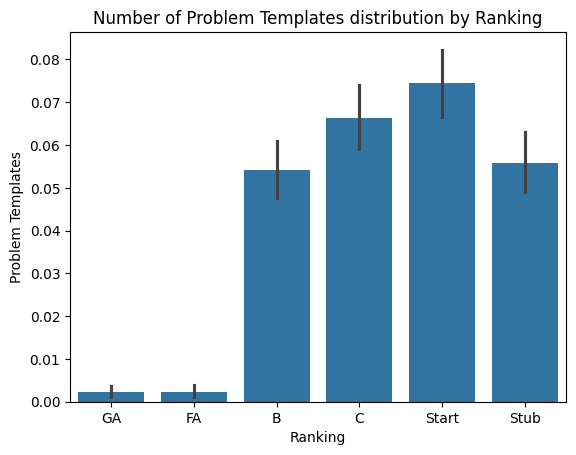

In [11]:
problem_templates = df.columns[df.columns.str.startswith("T:")].to_list()
problem_templates = [template for template in problem_templates if not template.startswith("T:pp-")]

df["Problem Templates"] = df.loc[:, problem_templates].sum(axis=1)

sns.barplot(data=df, y="Problem Templates", x="Ranking")
plt.title("Number of Problem Templates distribution by Ranking")
plt.show()

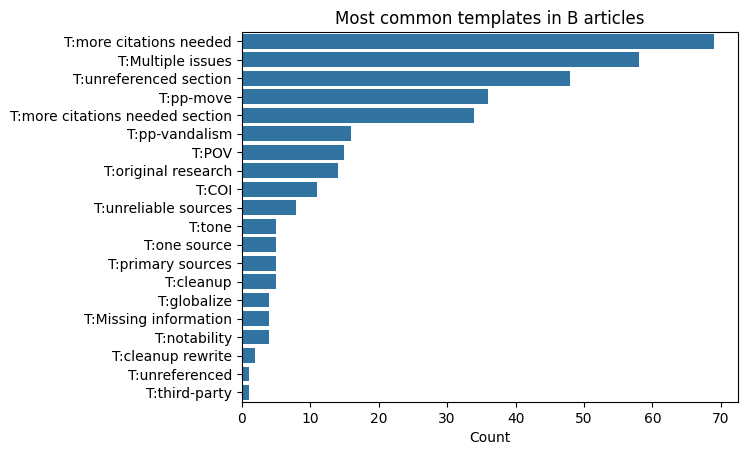

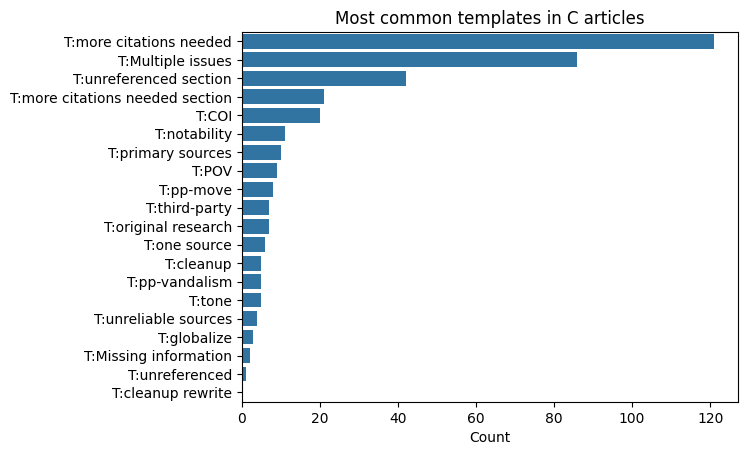

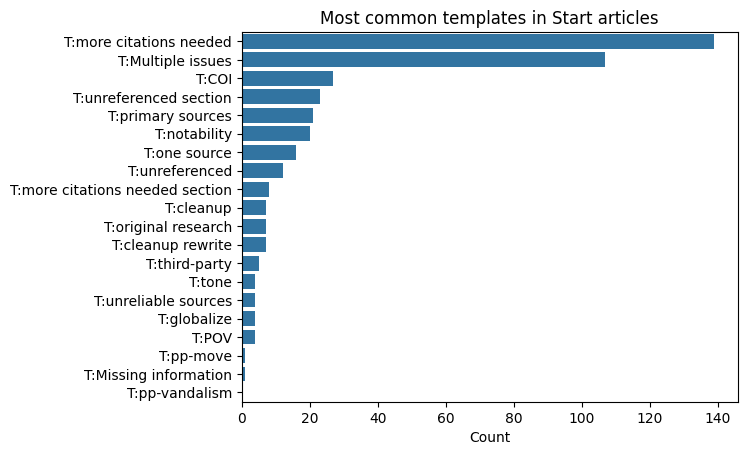

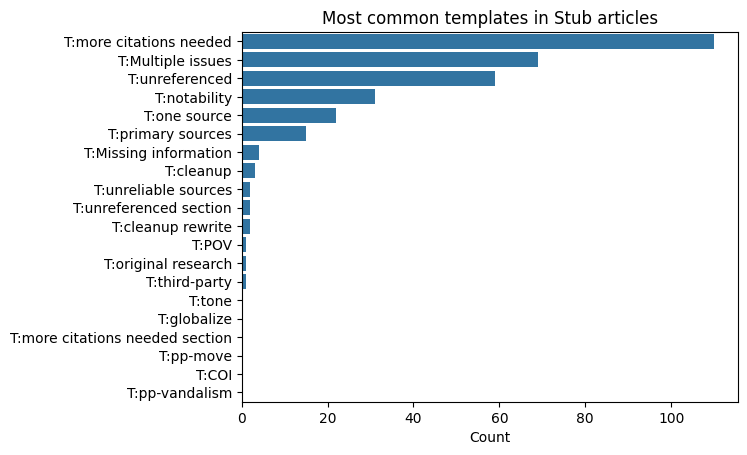

In [12]:

# which templates are most common on non FA and GA articles?
# (aggregate by ranking)
non_fa = df[(df["Ranking"] != "FA") & (df["Ranking"] != "GA")]
non_fa_templates = non_fa.loc[:, (non_fa.columns.str.startswith("T:")) | (non_fa.columns == "Ranking")].groupby("Ranking").sum()
non_fa_templates = non_fa_templates.T
non_fa_templates = non_fa_templates[non_fa_templates.sum(axis=1) > 10]

# plot each seperately
for column in non_fa_templates.columns:
    non_fa_templates.sort_values(by=column, ascending=False, inplace=True)
    sns.barplot(y=non_fa_templates.index, x=non_fa_templates[column])
    plt.title(f"Most common templates in {column} articles")
    plt.xlabel("Count")
    plt.ylabel(None)
    plt.show()

Hypothesis: Stub and start articles are less likely to have "section" templates

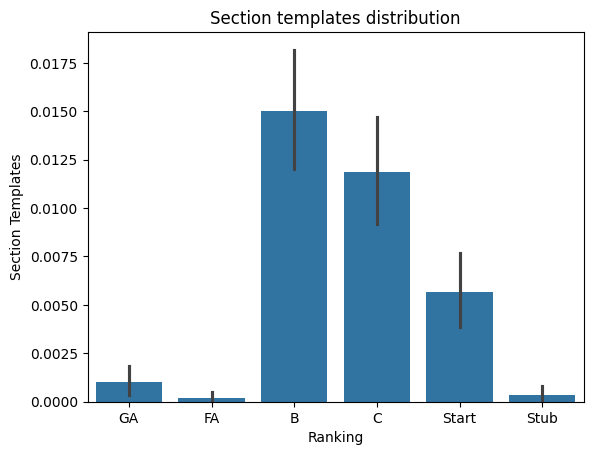

In [13]:
# number of "section" templates by ranking
df["Section Templates"] = df.loc[:, df.columns.str.endswith("section")].sum(axis=1)
sns.barplot(data=df, y="Section Templates", x="Ranking")
plt.title("Section templates distribution")
plt.show()


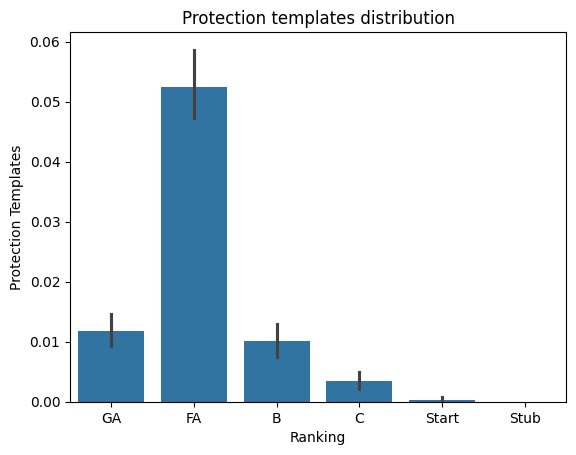

In [14]:
# number of protection templates
df["Protection Templates"] = df.loc[:, df.columns.str.startswith("T:pp-")].sum(axis=1)
sns.barplot(data=df, y="Protection Templates", x="Ranking")
plt.title("Protection templates distribution")
plt.show()

All told, it seems like our most helpful metrics using template are:

- number of "problem" template
- presense of a protection template
- number of "section templates"

In [15]:
# drop T columns
df.drop(columns=df.columns[df.columns.str.startswith("T:")], inplace=True)
df.drop(columns=["Warning Templates"])

,Title,Bytes,Media Count,Ranking,Reference Density,Reference Quality,Revision Size Mean,Revision Size Std,Reference Count,High Revisions per Day,High Undo per Revision,Grammar Quality Weighted,Neutrality Weighted,Revision Size Mean Norm,Revision Size Std Norm,Problem Templates,Section Templates,Protection Templates
0,Abraham Lincoln,209929,791,GA,0.179483,0.199012,20.356713,3559.371668,139.0,True,False,199616.698246,181201.873684,0.000097,0.016955,0.0,0.0,0.0
1,Ayn Rand,89798,455,GA,0.088646,0.111607,-3.691383,367.038389,31.0,True,True,88165.309091,65307.636364,-0.000041,0.004087,0.0,0.0,0.0
2,Amphibian,165111,579,FA,0.213550,0.078031,72.901804,8708.255946,113.0,False,False,163641.169139,111707.145401,0.000442,0.052742,0.0,0.0,0.0
3,Apollo 11,191034,634,FA,0.197621,0.162486,80.166333,1200.463989,136.0,False,False,183708.212389,162294.371681,0.000420,0.006284,0.0,0.0,0.0
4,Apollo 8,98322,382,FA,0.091989,0.075964,22.565130,594.323011,36.0,False,False,95664.648649,79720.540541,0.000230,0.006045,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35955,Louis-Stanislas Montjoie,5242,58,B,0.040000,0.000000,47.300000,92.143963,2.0,True,False,5242.000000,2096.800000,0.009023,0.017578,0.0,0.0,0.0
35956,Hurricane Rafael,146,1,C,0.000000,0.000000,100.700000,284.071384,0.0,True,False,0.000000,0.000000,0.689726,1.945694,0.0,0.0,0.0
35957,Shaheda Akter Ripa,4353,11,Start,0.148936,0.000000,53.000000,47.100955,7.0,True,False,4353.000000,1339.384615,0.012176,0.010820,0.0,0.0,0.0
35958,Nancy Bowen,25765,84,B,0.000000,0.000000,2163.800000,1936.465275,0.0,True,False,23422.727273,4684.545455,0.083982,0.075159,0.0,0.0,0.0


# Model Selection

In [16]:
# model selction, we'll try KNN, Logistic Regression, SVM, a Decision Tree, Random Forest and a MLP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

In [17]:
# Test Train split
# we need to make sure that the split is even across rankings
df.dropna(inplace=True)
#drop T: columns
X = df.drop(columns=["Title", "Ranking", "Warning Templates"])
y = df["Ranking"]
y = y.map({"Stub": 0, "Start": 1, "C": 2, "B": 3, "GA": 4, "FA": 5})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

KNN
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      1160
           1       0.37      0.39      0.38      1178
           2       0.31      0.29      0.30      1189
           3       0.32      0.26      0.29      1189
           4       0.37      0.37      0.37      1181
           5       0.57      0.59      0.58      1175

    accuracy                           0.44      7072
   macro avg       0.43      0.44      0.43      7072
weighted avg       0.43      0.44      0.43      7072



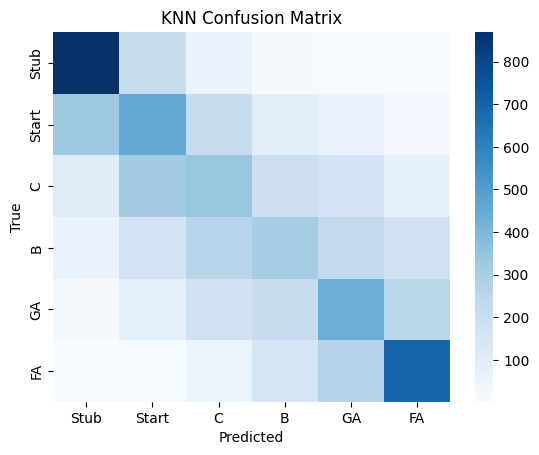

In [18]:
# KNN
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("KNN")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
# fix scale labels
plt.xticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.yticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.title("KNN Confusion Matrix")
plt.show()

Logistic Regression
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      1160
           1       0.33      0.40      0.36      1178
           2       0.29      0.32      0.31      1189
           3       0.27      0.12      0.17      1189
           4       0.35      0.26      0.30      1181
           5       0.52      0.58      0.55      1175

    accuracy                           0.42      7072
   macro avg       0.40      0.43      0.40      7072
weighted avg       0.40      0.42      0.40      7072



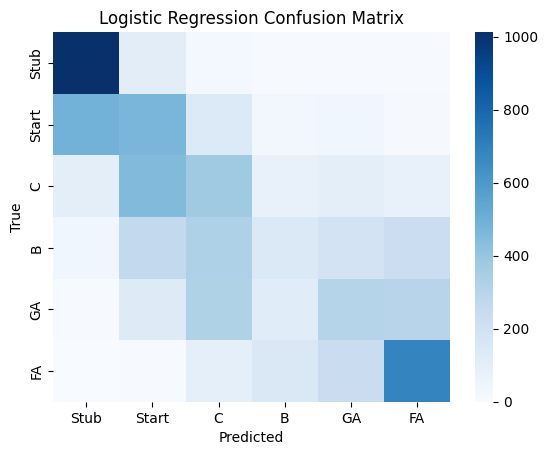

In [19]:
# Logistic Regression

logistic = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
# fix scale labels
plt.xticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.yticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

SVM
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1160
           1       0.40      0.43      0.41      1178
           2       0.36      0.36      0.36      1189
           3       0.39      0.20      0.26      1189
           4       0.41      0.37      0.39      1181
           5       0.55      0.74      0.63      1175

    accuracy                           0.48      7072
   macro avg       0.47      0.49      0.47      7072
weighted avg       0.47      0.48      0.47      7072



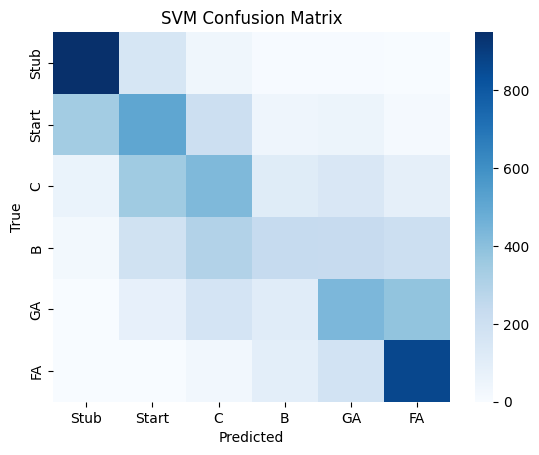

In [20]:
# SVM

svm = make_pipeline(StandardScaler(), SVC())
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("SVM")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
# fix scale labels
plt.xticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.yticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix")
plt.show()

Decision Tree
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      1160
           1       0.34      0.32      0.33      1178
           2       0.28      0.29      0.28      1189
           3       0.28      0.28      0.28      1189
           4       0.34      0.35      0.34      1181
           5       0.52      0.51      0.52      1175

    accuracy                           0.40      7072
   macro avg       0.40      0.40      0.40      7072
weighted avg       0.40      0.40      0.40      7072



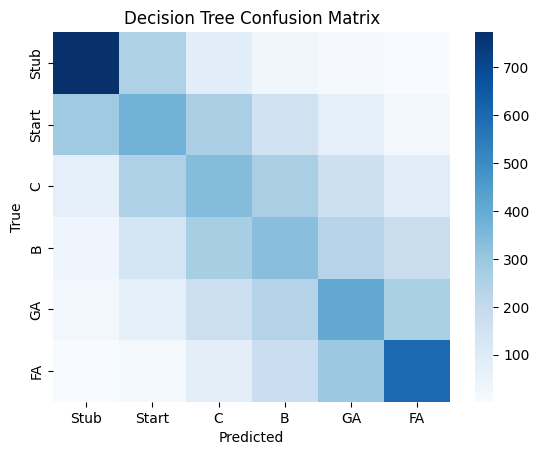

In [21]:
# Decision Tree

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("Decision Tree")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
# fix scale labels
plt.xticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.yticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree Confusion Matrix")
plt.show()

Random Forest
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1160
           1       0.44      0.43      0.44      1178
           2       0.36      0.36      0.36      1189
           3       0.36      0.25      0.29      1189
           4       0.41      0.43      0.42      1181
           5       0.58      0.74      0.65      1175

    accuracy                           0.49      7072
   macro avg       0.48      0.49      0.48      7072
weighted avg       0.48      0.49      0.48      7072



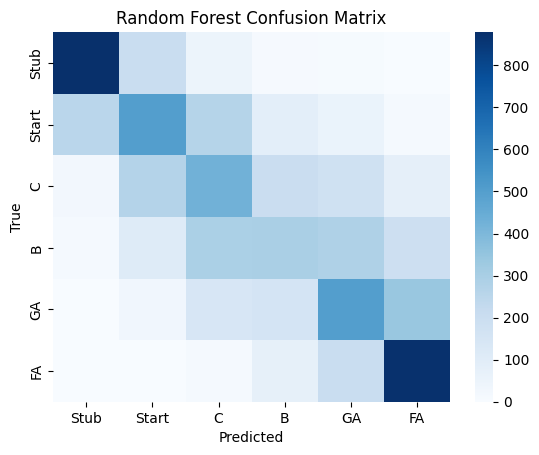

In [22]:
# Random Forest

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
# fix scale labels
plt.xticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.yticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

Iteration 1, loss = 1.55726406
Iteration 2, loss = 1.37564186
Iteration 3, loss = 1.31632121
Iteration 4, loss = 1.28835179
Iteration 5, loss = 1.27142553
Iteration 6, loss = 1.25910771
Iteration 7, loss = 1.25008074
Iteration 8, loss = 1.24174398
Iteration 9, loss = 1.23501795
Iteration 10, loss = 1.22818903
Iteration 11, loss = 1.22281576
Iteration 12, loss = 1.21673854
Iteration 13, loss = 1.21245992
Iteration 14, loss = 1.20808212
Iteration 15, loss = 1.20400506
Iteration 16, loss = 1.20064239
Iteration 17, loss = 1.19769718
Iteration 18, loss = 1.19417904
Iteration 19, loss = 1.19091373
Iteration 20, loss = 1.18933927
Iteration 21, loss = 1.18682727
Iteration 22, loss = 1.18430431
Iteration 23, loss = 1.18255748
Iteration 24, loss = 1.17956890
Iteration 25, loss = 1.17874275
Iteration 26, loss = 1.17683843
Iteration 27, loss = 1.17475020
Iteration 28, loss = 1.17322997
Iteration 29, loss = 1.17139279
Iteration 30, loss = 1.16990353
Iteration 31, loss = 1.16835075
Iteration 32, los

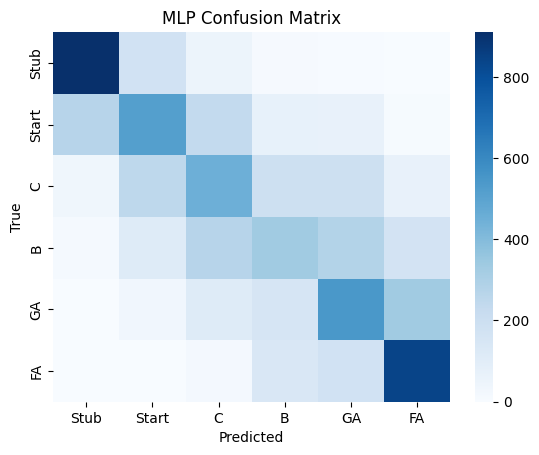

In [23]:
# MLP

mlp = make_pipeline(StandardScaler(), MLPClassifier(verbose=True, max_iter=1000))
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("MLP")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
# fix scale labels
plt.xticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.yticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP Confusion Matrix")
plt.show()

I'm plesantly surprised by some of the results with the simpler models, but I think that Random Forest and MLP are the most promising

In [24]:
# Random Forest Hyperparameter tuning
results = []
values = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]

for n_estimators in values:
    forest = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    scores = cross_val_score(forest, X, y, cv=5, scoring="f1_weighted")
    print(f"n_estimators: {n_estimators} - {np.mean(scores)}")
    results.append(np.mean(scores))

n_estimators: 1 - 0.37835880505936664
n_estimators: 5 - 0.41437332220351636
n_estimators: 10 - 0.4340610042200554
n_estimators: 20 - 0.4489014140771828
n_estimators: 30 - 0.45572958188015084
n_estimators: 40 - 0.458744863485233
n_estimators: 50 - 0.45938711232789614
n_estimators: 75 - 0.46197481110321287
n_estimators: 100 - 0.46135725203564554
n_estimators: 150 - 0.4659778794091888
n_estimators: 200 - 0.4638603083956168


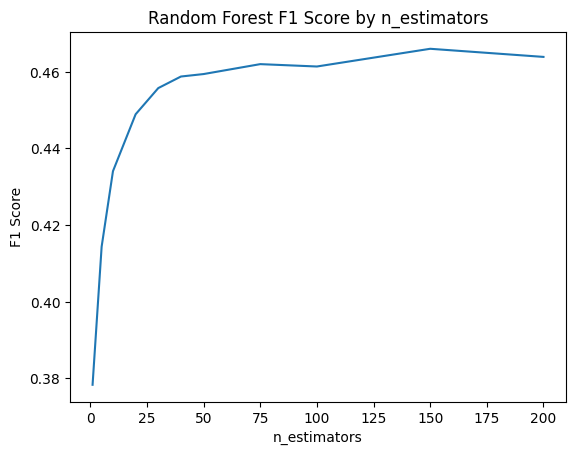

In [25]:
plt.plot(values, results)
plt.xlabel("n_estimators")
plt.ylabel("F1 Score")
plt.title("Random Forest F1 Score by n_estimators")
plt.show()

In [26]:
# Random Forest depth tuning
results = []
percent_at_max_depth = []
values = range(5, 76, 5)

for min_samples_split in values:
    forest = RandomForestClassifier(n_estimators=100, min_samples_split=min_samples_split, n_jobs=-1)
    # find percent of trees that are at max depth
    scores = cross_val_score(forest, X, y, cv=5, scoring="f1_weighted")

    print(f"min_samples_split: {min_samples_split} - {np.mean(scores)}")
    results.append(np.mean(scores))

min_samples_split: 5 - 0.4653393522529942
min_samples_split: 10 - 0.4659288614348836
min_samples_split: 15 - 0.4674854773308576
min_samples_split: 20 - 0.46916603490277886
min_samples_split: 25 - 0.46919206961335885
min_samples_split: 30 - 0.47068733129235757
min_samples_split: 35 - 0.46956945375734255
min_samples_split: 40 - 0.4687584314281098
min_samples_split: 45 - 0.46899593034268977
min_samples_split: 50 - 0.46797545627133397
min_samples_split: 55 - 0.467411460600049
min_samples_split: 60 - 0.4664473352602
min_samples_split: 65 - 0.4667997731555905
min_samples_split: 70 - 0.4663858070958372
min_samples_split: 75 - 0.46809960287463026


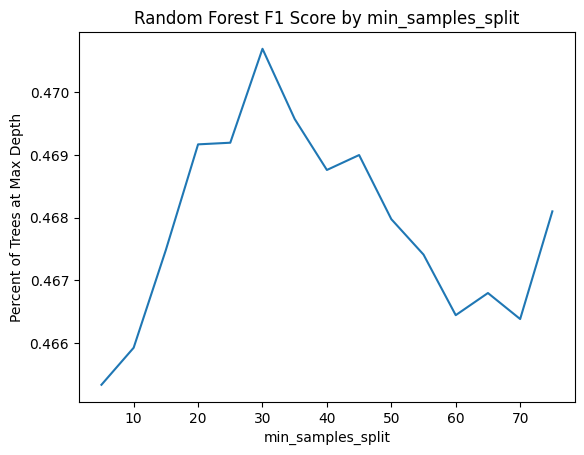

In [27]:
plt.plot(values, results)
# plot percent of trees at max depth on a secondary y axis
plt.ylabel("F1 Score")
plt.ylabel("Percent of Trees at Max Depth")
plt.xlabel("min_samples_split")
plt.title("Random Forest F1 Score by min_samples_split")
plt.show()

Random Forest
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1160
           1       0.47      0.45      0.46      1178
           2       0.38      0.40      0.39      1189
           3       0.39      0.24      0.30      1189
           4       0.41      0.45      0.43      1181
           5       0.57      0.76      0.65      1175

    accuracy                           0.51      7072
   macro avg       0.50      0.51      0.50      7072
weighted avg       0.50      0.51      0.50      7072



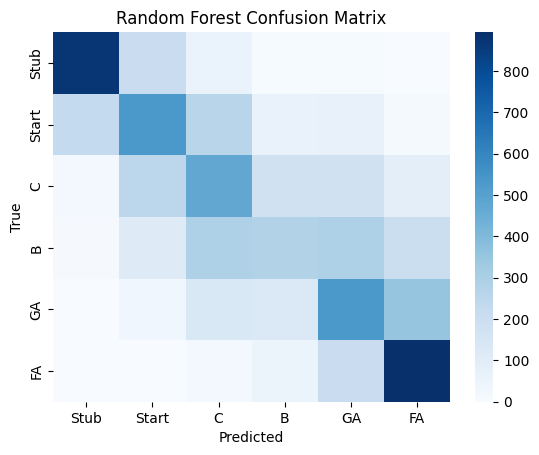

In [28]:
# Final model
forest = RandomForestClassifier(n_estimators=100, min_samples_split=25, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
# fix scale labels
plt.xticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.yticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

Iteration 1, loss = 1.52712931
Iteration 2, loss = 1.37603026
Iteration 3, loss = 1.31935826
Iteration 4, loss = 1.29004909
Iteration 5, loss = 1.27120507
Iteration 6, loss = 1.25778926
Iteration 7, loss = 1.24801848
Iteration 8, loss = 1.24035558
Iteration 9, loss = 1.23265654
Iteration 10, loss = 1.22602923
Iteration 11, loss = 1.22192801
Iteration 12, loss = 1.21588943
Iteration 13, loss = 1.21154311
Iteration 14, loss = 1.20761642
Iteration 15, loss = 1.20333131
Iteration 16, loss = 1.19969546
Iteration 17, loss = 1.19688377
Iteration 18, loss = 1.19330660
Iteration 19, loss = 1.19114159
Iteration 20, loss = 1.18865135
Iteration 21, loss = 1.18606725
Iteration 22, loss = 1.18362520
Iteration 23, loss = 1.18208917
Iteration 24, loss = 1.18079256
Iteration 25, loss = 1.17781647
Iteration 26, loss = 1.17656676
Iteration 27, loss = 1.17434712
Iteration 28, loss = 1.17322239
Iteration 29, loss = 1.17108551
Iteration 30, loss = 1.16976604
Iteration 31, loss = 1.16778254
Iteration 32, los

/Users/nathan/Projects/school/cs5830/cs5830final/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


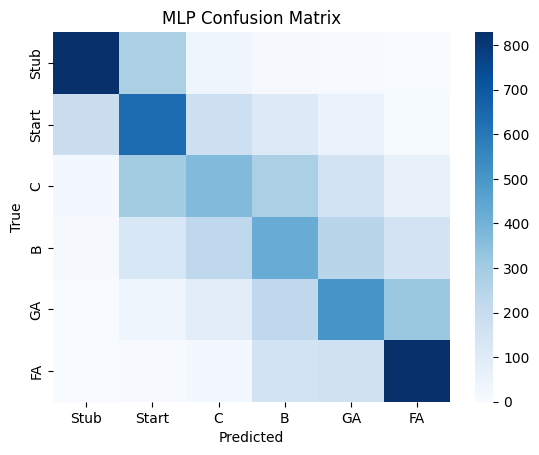

In [30]:
## MLP

mlp = make_pipeline(StandardScaler(), MLPClassifier(max_iter=10000, verbose=True, n_iter_no_change=10000))

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("MLP")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
# fix scale labels
plt.xticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.yticks(labels=["Stub", "Start", "C", "B", "GA", "FA"], ticks=np.arange(6) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP Confusion Matrix")
plt.show()

# Conclusion
I think ultimately, this project is a failure. Not because our f1 scores aren't high enough, or because we can't draw conclusions about what makes an article good. Rather, this project is a failure because we had a fundamental misunderstanding of what we were predicting. We thought we were predicting the quality of a wikipedia article based on it's charactaristics. What we are actually predicting is the behavior of anywhere from 1 to thousands or more different people, and how they treat the rating system, the subject, and Wikipedia itself.

This is an informative failure, however, because it informs how this problem should be approached in the future. I think we became preoccupied with describing the state of an article. A better approach would be to focus more on describing the history of an article, and characterizing the ways that articles evolve over time. It would also go a long way to combine that analysis with an analysis of the editors themselves. Characterizing the kinds of edits that different editors make and the different articles and projects those editors work on would enable us to better understand how an edit might affect the quality of an article. Lastly, a better understanding of the subject of an article, so as to understand how well the content of the article suits the subject.